## Assignment 13

In [165]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as ss
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
from pylab import *
import itertools
from lmfit import Model

np.random.seed(12345678)  # for reproducibility, set random seed

# Read in data
df = pd.read_csv('../output.csv')

nvox = 64*64*48 # assume number of voxels per bin
df['weighted'] = df['synapses']/df['unmasked']*nvox

xvals = df['cx'].unique()
yvals = df['cy'].unique()
zvals = df['cz'].unique()

# Get rid of the blank edges
bottom = 0;
top = len(xvals);
right = 0;
left = len(yvals);
for z in zvals:
    this_z = df[df['cz']==z]
    
    # X direction
    xhist, bin_edges = np.histogram(this_z['cx'], weights = this_z['unmasked']/(nvox*len(yvals)), bins=len(xvals))
    
    bottom = max(bottom, np.argmax(xhist>0.5))
    top = min(top, len(xvals)-np.argmax(xhist[::-1]>0.5))
    
    # Y direction
    yhist, bin_edges = np.histogram(this_z['cy'], weights = this_z['unmasked']/(nvox*len(xvals)), bins=len(yvals))
    
    right = max(right, np.argmax(yhist>0.5))
    left = min(left, len(yvals)-np.argmax(yhist[::-1]>0.5))

# Copy new dataset without edges
df2 = df.copy()
for z in zvals:
    df2.drop(df2.index[(df2['cx']<xvals[bottom]) | (df2['cx']>=xvals[top])], inplace=True)
    df2.drop(df2.index[(df2['cy']<yvals[right]) | (df2['cy']>=yvals[left])], inplace=True)

xvals = df2['cx'].unique()
yvals = df2['cy'].unique()
zvals = df2['cz'].unique()

df2.head()

,cx,cy,cz,unmasked,synapses,weighted
6292,448,1369,55,126357,153,238.063772
6293,448,1369,166,139932,207,290.840237
6294,448,1369,277,150269,194,253.824488
6295,448,1369,388,138071,159,226.410122
6296,448,1369,499,150842,258,336.278119


### Fit 2D data to X-Y coordinate sums

In [13]:
dfxy = pd.pivot_table(df2, index='cy', columns='cx', values='weighted', aggfunc=np.mean)

df3 = dfxy.unstack().rename('weighted').reset_index()
df3.head()

,cx,cy,weighted
0,448,1369,250.321598
1,448,1408,223.463253
2,448,1447,259.299478
3,448,1486,241.491077
4,448,1525,279.953094


In [21]:
from numpy.polynomial import polynomial as P

def polyfit2d(x, y, f, deg):
    x = np.asarray(x)
    y = np.asarray(y)
    f = np.asarray(f)
    deg = np.asarray(deg)
    vander = P.polyvander2d(x, y, deg)
    vander = vander.reshape((-1,vander.shape[-1]))
    f = f.reshape((vander.shape[0],))
    c = np.linalg.lstsq(vander, f)[0]
    return c.reshape(deg+1)

x_point = np.array(df3['cx'])
y_point = np.array(df3['cy'])
synapses = np.array(df3['weighted'])

for deg in range(5):
    popt = polyfit2d(x_point, y_point, synapses, deg=[deg, deg])
    chi_squared = np.sum((P.polyval2d(x_point, y_point, popt) - synapses) ** 2)
    reduced_chi_squared = chi_squared / (len(x_point) + len(y_point) - len(popt))
    print 'Testing polynomial model of degree =', deg
    print 'The degrees of freedom for this test is', len(x_point) + len(y_point) - len(popt)
    print 'The chi squared value is: ', ("%.2f" % chi_squared)
    print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
    print 

popt = polyfit2d(np.log(x_point), np.log(y_point), synapses, deg=[1, 1])
chi_squared = np.sum((P.polyval2d(np.log(x_point), np.log(y_point), popt) - synapses) ** 2)
reduced_chi_squared = chi_squared / (len(x_point) + len(y_point) - len(popt))
print 'Testing logarithmic model'
print 'The degrees of freedom for this test is', len(x_point) + len(y_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

popt = polyfit2d(np.log(x_point), np.log(y_point), np.log(synapses), deg=[1, 1])
chi_squared = np.sum((np.exp(P.polyval2d(np.log(x_point), np.log(y_point), popt)) - synapses) ** 2)
reduced_chi_squared = chi_squared / (len(x_point) + len(y_point) - len(popt))
print 'Testing powerlaw model'
print 'The degrees of freedom for this test is', len(x_point) + len(y_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

print '2D polynomial of degree = 2 gives the best fit'

Testing polynomial model of degree = 0
The degrees of freedom for this test is 6383
The chi squared value is:  4103057.80
The reduced chi squared value is:  642.81

Testing polynomial model of degree = 1
The degrees of freedom for this test is 6382
The chi squared value is:  3051500.33
The reduced chi squared value is:  478.14

Testing polynomial model of degree = 2
The degrees of freedom for this test is 6381
The chi squared value is:  2621617.98
The reduced chi squared value is:  410.85

Testing polynomial model of degree = 3
The degrees of freedom for this test is 6380
The chi squared value is:  2910471.17
The reduced chi squared value is:  456.19

Testing polynomial model of degree = 4
The degrees of freedom for this test is 6379
The chi squared value is:  10483687.82
The reduced chi squared value is:  1643.47

Testing logarithmic model
The degrees of freedom for this test is 6382
The chi squared value is:  3194949.04
The reduced chi squared value is:  500.62

Testing powerlaw mode

### Plot the fitted and actual number of synapses distribution

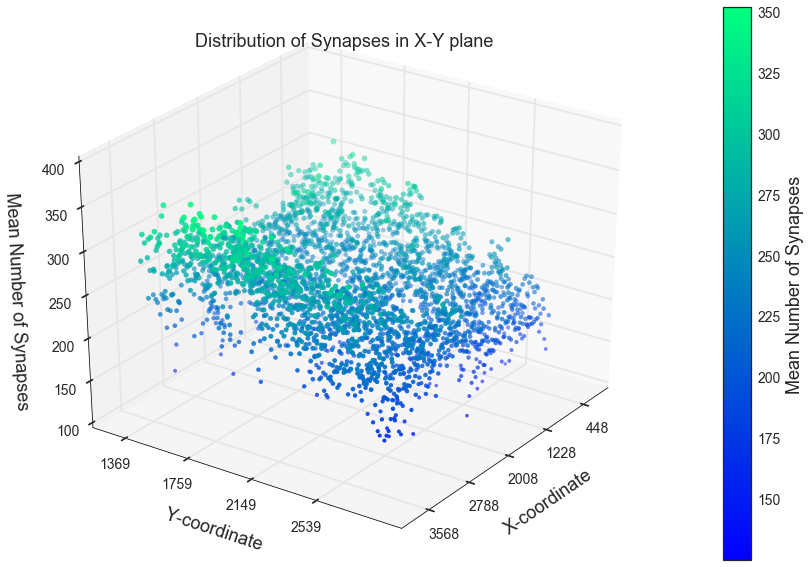

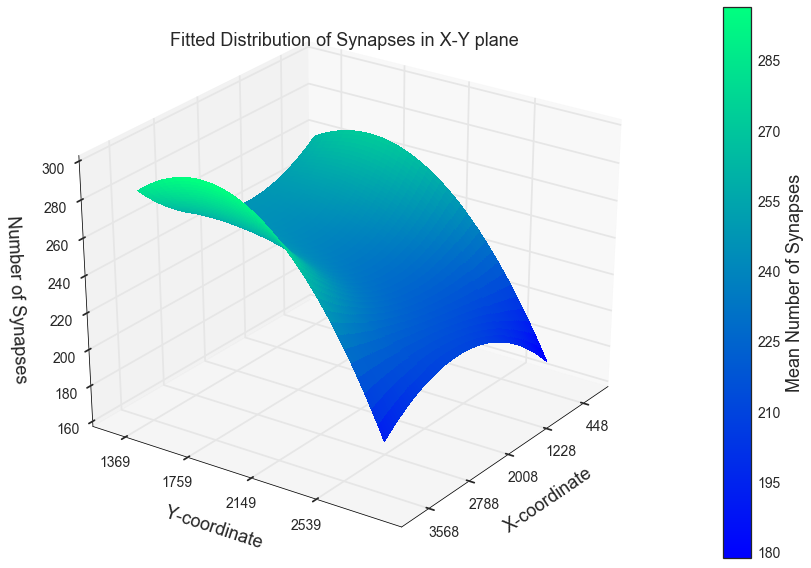

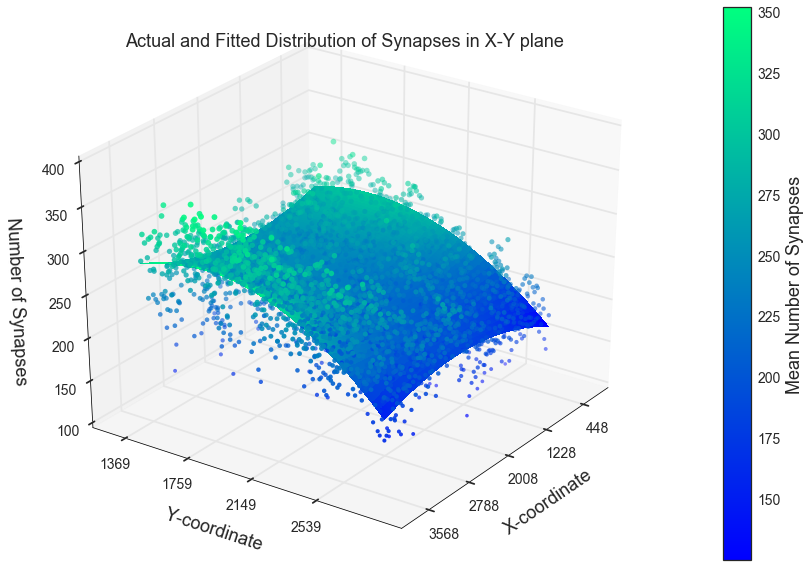

In [23]:
popt = polyfit2d(x_point, y_point, synapses, deg=[2, 2])
pred = P.polyval2d(x_point, y_point, popt)
df3['pred'] = pred

sns.set_style('white')

fs = 18
tfs = 14

ax = plt.figure(figsize = (12, 8)).gca(projection = '3d')
patches = ax.scatter(xs = df3['cx'], ys = df3['cy'], zs = df3['weighted'], 
                     s = df3['weighted']/10, c = df3['weighted'], cmap = 'winter',
                     edgecolors = [0,0,0,0])

plt.xticks(xvals[::20], fontsize=tfs)
plt.yticks(yvals[::10], fontsize=tfs)
#plt.zticks(df2['weighted'].unique()[0, 1000, 2000, 3000], fontsize=tfs)
#ax.zaxis.set_ticks(df2['weighted'].unique()[::3])
plt.tick_params(axis='both', which='major', labelsize=tfs)
plt.xlabel('X-coordinate', fontsize = fs, labelpad=20)
plt.ylabel('Y-coordinate', fontsize = fs, labelpad=20)
plt.gca().set_zlabel('Mean Number of Synapses', fontsize = fs, labelpad=20)
plt.title("Distribution of Synapses in X-Y plane", fontsize=fs)
cbar = plt.colorbar(patches)
cbar.ax.tick_params(labelsize=tfs) 
cbar.ax.set_ylabel('Mean Number of Synapses', fontsize=fs)
plt.tight_layout()

plt.savefig('./figs/weighted_synapses/XY_means.png', format='png', dpi=300)
ax.view_init(azim = 35)
plt.savefig('./figs/weighted_synapses/XY_means_azim_35.png', format='png', dpi=300)

plt.show()
    
X, Y = np.meshgrid(xvals, yvals)
Z = pd.pivot_table(df3, index='cy', columns='cx', values='pred')

ax = plt.figure(figsize = (12, 8)).gca(projection = '3d')
patches = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap = 'winter',
                          linewidth=0, antialiased=False)

plt.xticks(xvals[::20], fontsize=tfs)
plt.yticks(yvals[::10], fontsize=tfs)
#plt.zticks(df2['weighted'].unique()[0, 1000, 2000, 3000], fontsize=tfs)
#ax.zaxis.set_ticks(df2['weighted'].unique()[::3])
# ax.view_init(azim = 35)
plt.tick_params(axis='both', which='major', labelsize=tfs)
plt.xlabel('X-coordinate', fontsize = fs, labelpad=20)
plt.ylabel('Y-coordinate', fontsize = fs, labelpad=20)
plt.gca().set_zlabel('Number of Synapses', fontsize = fs, labelpad=20)
plt.title("Fitted Distribution of Synapses in X-Y plane", fontsize=fs)
cbar = plt.colorbar(patches)
cbar.ax.tick_params(labelsize=tfs) 
cbar.ax.set_ylabel('Mean Number of Synapses', fontsize=fs)

plt.tight_layout()

plt.savefig('./figs/weighted_synapses/XY_quadratic_fit.png', format='png', dpi=300)
ax.view_init(azim = 35)
plt.savefig('./figs/weighted_synapses/XY_quadratic_fit_azim_35.png', format='png', dpi=300)

plt.show()

ax = plt.figure(figsize = (12, 8)).gca(projection = '3d')
patches = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap = 'winter',
                          linewidth=0, antialiased=False)
patches = ax.scatter(xs = df3['cx'], ys = df3['cy'], zs = df3['weighted'], 
                     s = df3['weighted']/10, c = df3['weighted'], cmap = 'winter',
                     edgecolors = [0,0,0,0])

plt.xticks(xvals[::20], fontsize=tfs)
plt.yticks(yvals[::10], fontsize=tfs)
#plt.zticks(df2['weighted'].unique()[0, 1000, 2000, 3000], fontsize=tfs)
#ax.zaxis.set_ticks(df2['weighted'].unique()[::3])
# ax.view_init(azim = 35)
plt.tick_params(axis='both', which='major', labelsize=tfs)
plt.xlabel('X-coordinate', fontsize = fs, labelpad=20)
plt.ylabel('Y-coordinate', fontsize = fs, labelpad=20)
plt.gca().set_zlabel('Number of Synapses', fontsize = fs, labelpad=20)
plt.title("Actual and Fitted Distribution of Synapses in X-Y plane", fontsize=fs)
cbar = plt.colorbar(patches)
cbar.ax.tick_params(labelsize=tfs) 
cbar.ax.set_ylabel('Mean Number of Synapses', fontsize=fs)

plt.tight_layout()

plt.savefig('./figs/weighted_synapses/XY_actual_fit.png', format='png', dpi=300)
ax.view_init(azim = 35)
plt.savefig('./figs/weighted_synapses/XY_actual_fit_azim_35.png', format='png', dpi=300)

plt.show()

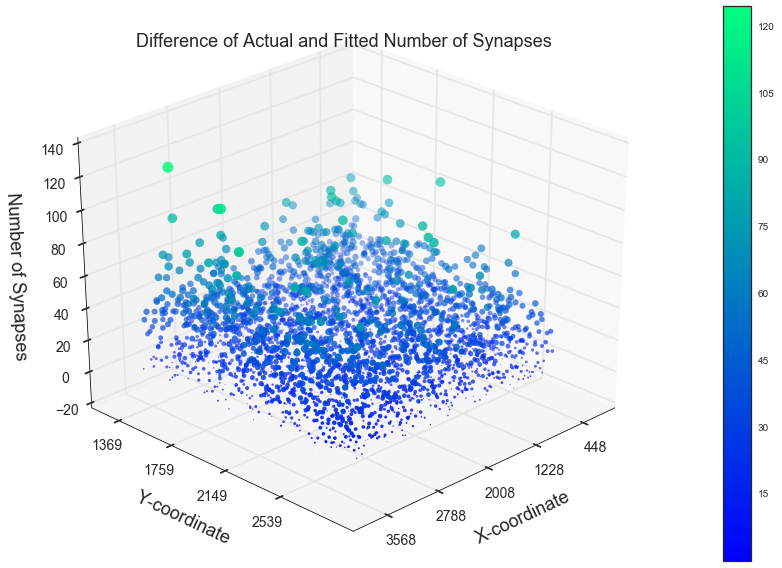

In [27]:
residual = abs(pred - df3['weighted'])

sns.set_style('white')

fs = 18
tfs = 14

ax = plt.figure(figsize = (12, 8)).gca(projection = '3d')
patches = ax.scatter(xs = df3['cx'], ys = df3['cy'], zs = residual, 
                     s = residual, c = residual, cmap = 'winter',
                     edgecolors = [0,0,0,0])

plt.xticks(xvals[::20], fontsize=tfs)
plt.yticks(yvals[::10], fontsize=tfs)
#plt.zticks(dfout['weighted'].unique()[0, 1000, 2000, 3000], fontsize=tfs)
#ax.zaxis.set_ticks(dfout['weighted'].unique()[::3])
ax.view_init(azim = 45)
plt.tick_params(axis='both', which='major', labelsize=tfs)
plt.xlabel('X-coordinate', fontsize = fs, labelpad=20)
plt.ylabel('Y-coordinate', fontsize = fs, labelpad=20)
plt.gca().set_zlabel('Number of Synapses', fontsize = fs, labelpad=20)
plt.title("Difference of Actual and Fitted Number of Synapses", fontsize=fs)
plt.colorbar(patches)
plt.tight_layout()
plt.show()

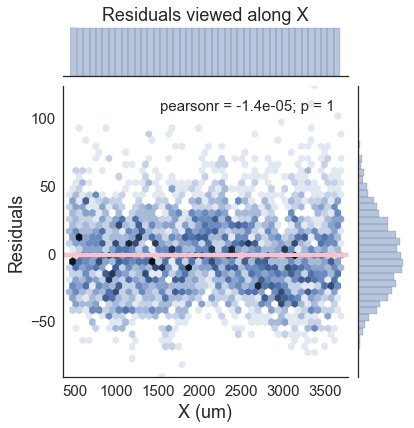

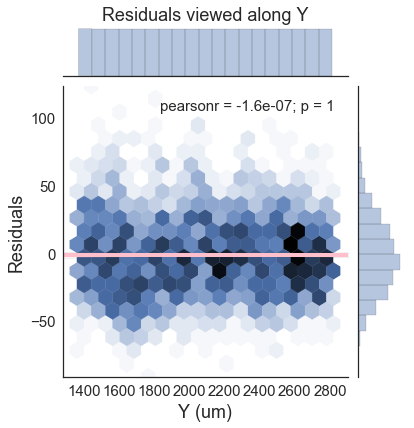

In [60]:
df3['resid'] = df3['pred'] - df3['weighted']

sns.set_style('white')

bottom = df3['resid'].min()
top = df3['resid'].max()

delta = 2*(xvals[1]-xvals[0])
extra = delta / (np.sqrt(3)/2)
left = np.min(xvals) - extra
right = np.max(xvals) + extra

with sns.plotting_context('notebook', font_scale=1.5):
    g = sns.jointplot(x='cx', y='resid', data = df3, kind='hex',
                      joint_kws={'gridsize':len(xvals)/2+1, 'extent':(left, right, bottom, top)},
                      marginal_kws={'bins':len(xvals)/2})
#     g = g.plot_marginals(sns.distplot, kde=True)
    g = g.plot_joint(sns.regplot, scatter=False, color='pink', line_kws={'linewidth': 4})
    sns.axlabel('X (um)', 'Residuals', fontsize=fs)
    plt.gcf().axes[1].set_title('Residuals viewed along X')
    plt.savefig('./figs/weighted_synapses/XY_quadratic_fit_X_resid.png', format='png', dpi=300)
    plt.show()
    
delta = 2*(yvals[1]-yvals[0])
extra = delta / (np.sqrt(3)/2)
left = np.min(yvals) - extra
right = np.max(yvals) + extra

with sns.plotting_context('notebook', font_scale=1.5):
    g = sns.jointplot(x='cy', y='resid', data = df3, kind='hex',
                      joint_kws={'gridsize':len(yvals)/2+1, 'extent':(left, right, bottom, top)},
                      marginal_kws={'bins':len(yvals)/2})
    g = g.plot_joint(sns.regplot, scatter=False, color='pink', line_kws={'linewidth': 4})
    sns.axlabel('Y (um)', 'Residuals', fontsize=fs)
    plt.gcf().axes[1].set_title('Residuals viewed along Y')
    plt.savefig('./figs/weighted_synapses/XY_quadratic_fit_Y_resid.png', format='png', dpi=300)
    plt.show()
    

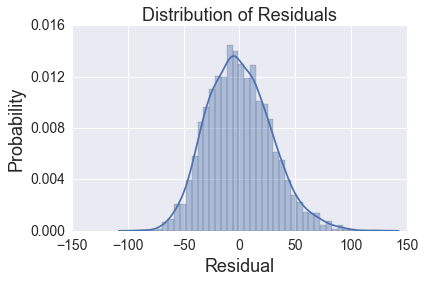

In [71]:
sns.set_style('darkgrid')

plt.figure()
sns.distplot(df3['resid'])
plt.xlabel('Residual', fontsize=fs)
plt.ylabel('Probability', fontsize=fs)
plt.yticks(np.linspace(0,0.016,5))
plt.tick_params(labelsize=tfs)
plt.title('Distribution of Residuals', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/XY_quadratic_fit_resid.png', format='png', dpi=300)
plt.show()

### Aligning Y-layers by means

In [6]:
mean = df2['weighted'].mean()
ymeans = [df2[df2['cy']==y]['weighted'].mean() for y in yvals]

df4 = df2.copy()
for y, ymean in zip(yvals, ymeans):
    df4.loc[df4['cy']==y, 'weighted'] = df4.loc[df4['cy']==y, 'weighted'] - (ymean - mean)

df4.head()

,cx,cy,cz,unmasked,synapses,weighted
6292,448,1369,55,126357,153,223.086287
6293,448,1369,166,139932,207,275.862752
6294,448,1369,277,150269,194,238.847003
6295,448,1369,388,138071,159,211.432637
6296,448,1369,499,150842,258,321.300634


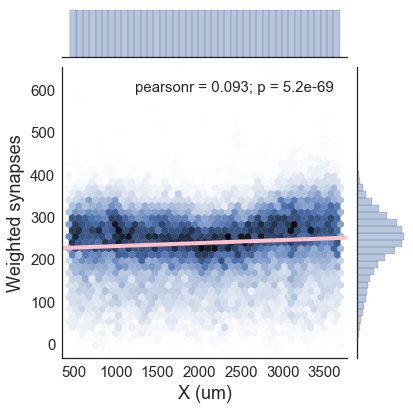

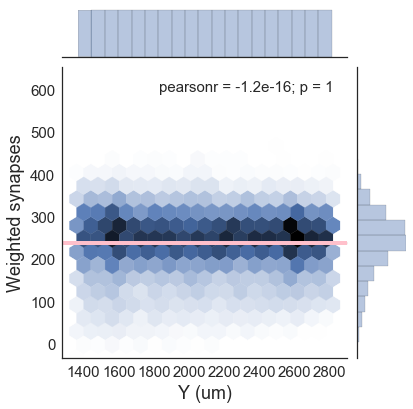

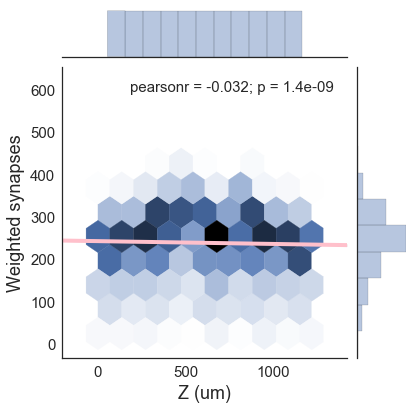

In [7]:
fs = 18

bottom = df4['weighted'].min()
top = df4['weighted'].max()

sns.set_style('white')

avals_list = [xvals, yvals, zvals]
anames = ['cx', 'cy', 'cz']
alabels = ['X (um)', 'Y (um)', 'Z (um)']
ascales = [2, 2, 1]

for avals, aname, alabel, ascale in zip(avals_list, anames, alabels, ascales):
    delta = 2*(avals[1]-avals[0])
    extra = delta / (np.sqrt(3)/2)
    left = np.min(avals) - extra
    right = np.max(avals) + extra
    
    with sns.plotting_context('notebook', font_scale=1.5):
        g = sns.jointplot(x=aname, y='weighted', data = df4, kind='hex',
                          joint_kws={'gridsize':len(avals)/ascale+1, 'extent':(left, right, bottom, top)},
                          marginal_kws={'bins':len(avals)/ascale})
        g = g.plot_joint(sns.regplot, scatter=False, color='pink', line_kws={'linewidth': 4})
        sns.axlabel(alabel, 'Weighted synapses', fontsize=fs)

### Fit 2D data to Y-aligned data

In [8]:
dfxy = pd.pivot_table(df4, index='cy', columns='cx', values='weighted', aggfunc=np.sum)

df5 = dfxy.unstack().rename('weighted').reset_index()
df5.head()

,cx,cy,weighted
0,448,1369,2588.785248
1,448,1408,2343.006049
2,448,1447,2759.237726
3,448,1486,2519.679015
4,448,1525,2931.327981


### Test different 2D models

In [9]:
from numpy.polynomial import polynomial as P

def polyfit2d(x, y, f, deg):
    x = np.asarray(x)
    y = np.asarray(y)
    f = np.asarray(f)
    deg = np.asarray(deg)
    vander = P.polyvander2d(x, y, deg)
    vander = vander.reshape((-1,vander.shape[-1]))
    f = f.reshape((vander.shape[0],))
    c = np.linalg.lstsq(vander, f)[0]
    return c.reshape(deg+1)

x_point = np.array(df5['cx'])
y_point = np.array(df5['cy'])
synapses = np.array(df5['weighted'])

for deg in range(5):
    popt = polyfit2d(x_point, y_point, synapses, deg=[deg, deg])
    chi_squared = np.sum((P.polyval2d(x_point, y_point, popt) - synapses) ** 2)
    reduced_chi_squared = chi_squared / (len(x_point) + len(y_point) - len(popt))
    print 'Testing polynomial model of degree =', deg
    print 'The degrees of freedom for this test is', len(x_point) + len(y_point) - len(popt)
    print 'The chi squared value is: ', ("%.2f" % chi_squared)
    print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
    print 

popt = polyfit2d(np.log(x_point), np.log(y_point), synapses, deg=[1, 1])
chi_squared = np.sum((P.polyval2d(np.log(x_point), np.log(y_point), popt) - synapses) ** 2)
reduced_chi_squared = chi_squared / (len(x_point) + len(y_point) - len(popt))
print 'Testing logarithmic model'
print 'The degrees of freedom for this test is', len(x_point) + len(y_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

popt = polyfit2d(np.log(x_point), np.log(y_point), np.log(synapses), deg=[1, 1])
chi_squared = np.sum((np.exp(P.polyval2d(np.log(x_point), np.log(y_point), popt)) - synapses) ** 2)
reduced_chi_squared = chi_squared / (len(x_point) + len(y_point) - len(popt))
print 'Testing powerlaw model'
print 'The degrees of freedom for this test is', len(x_point) + len(y_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

print '2D polynomial of degree = 2 gives the best fit'

Testing polynomial model of degree = 0
The degrees of freedom for this test is 6383
The chi squared value is:  359140617.31
The reduced chi squared value is:  56265.18

Testing polynomial model of degree = 1
The degrees of freedom for this test is 6382
The chi squared value is:  341398566.23
The reduced chi squared value is:  53493.98

Testing polynomial model of degree = 2
The degrees of freedom for this test is 6381
The chi squared value is:  304238990.09
The reduced chi squared value is:  47678.89

Testing polynomial model of degree = 3
The degrees of freedom for this test is 6380
The chi squared value is:  339413567.81
The reduced chi squared value is:  53199.62

Testing polynomial model of degree = 4
The degrees of freedom for this test is 6379
The chi squared value is:  1107177349.69
The reduced chi squared value is:  173565.97

Testing logarithmic model
The degrees of freedom for this test is 6382
The chi squared value is:  350037567.44
The reduced chi squared value is:  54847.6

### Plot the fitted and actual number of synapses distribution

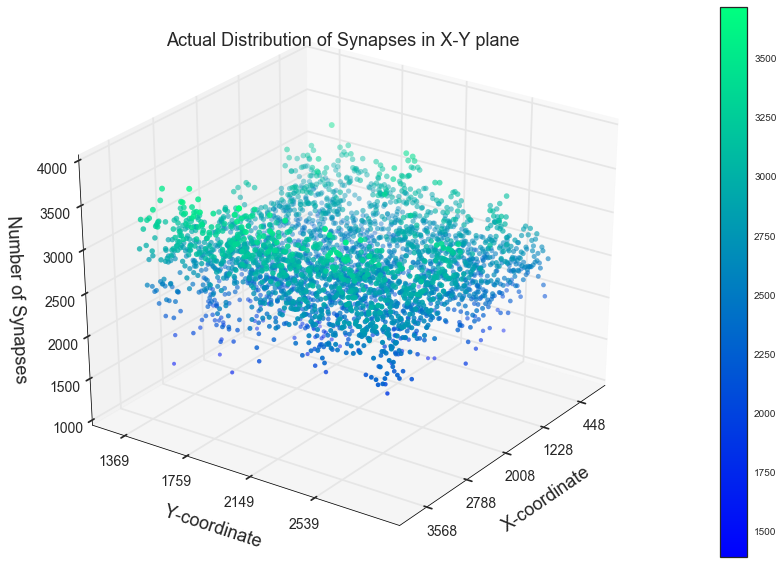

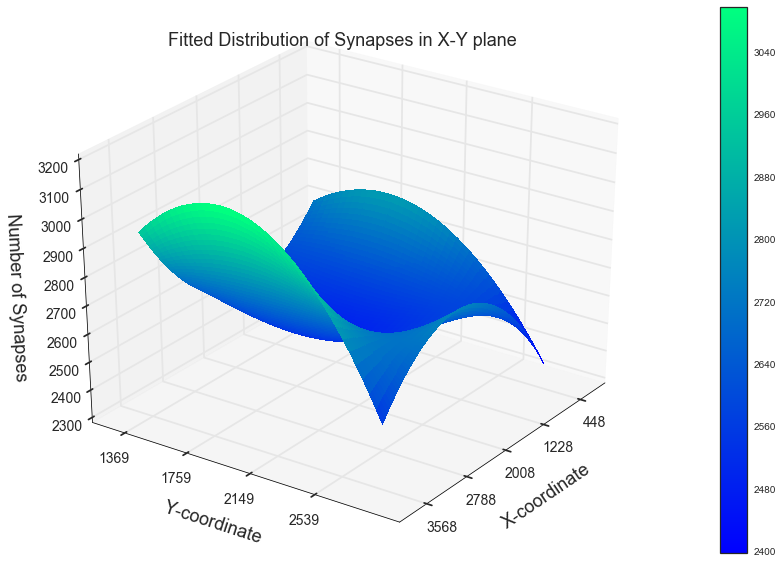

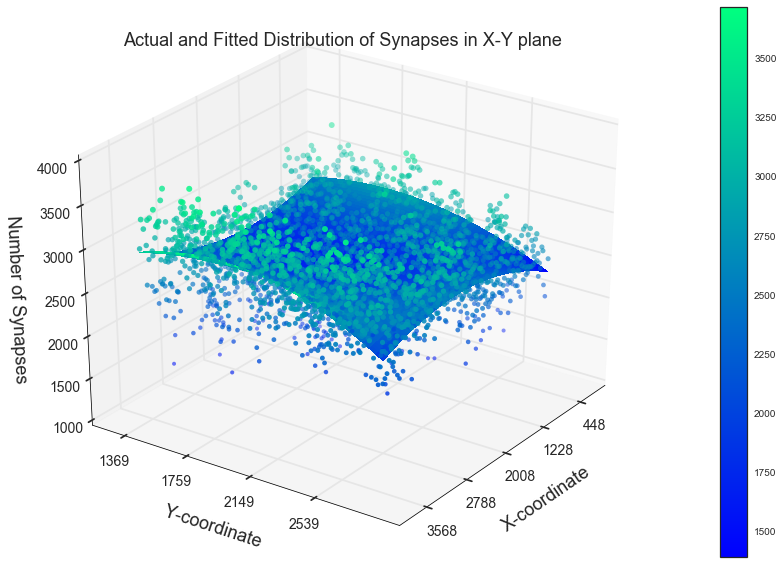

In [10]:
popt = polyfit2d(x_point, y_point, synapses, deg=[2, 2])
pred = P.polyval2d(x_point, y_point, popt)
df5['pred'] = pred

sns.set_style('white')

fs = 18
tfs = 14

ax = plt.figure(figsize = (12, 8)).gca(projection = '3d')
patches = ax.scatter(xs = df5['cx'], ys = df5['cy'], zs = df5['weighted'], 
                     s = df5['weighted']/100, c = df5['weighted'], cmap = 'winter',
                     edgecolors = [0,0,0,0])

plt.xticks(xvals[::20], fontsize=tfs)
plt.yticks(yvals[::10], fontsize=tfs)
#plt.zticks(df2['weighted'].unique()[0, 1000, 2000, 3000], fontsize=tfs)
#ax.zaxis.set_ticks(df2['weighted'].unique()[::3])
ax.view_init(azim = 35)
plt.tick_params(axis='both', which='major', labelsize=tfs)
plt.xlabel('X-coordinate', fontsize = fs, labelpad=20)
plt.ylabel('Y-coordinate', fontsize = fs, labelpad=20)
plt.gca().set_zlabel('Number of Synapses', fontsize = fs, labelpad=20)
plt.title("Actual Distribution of Synapses in X-Y plane", fontsize=fs)
plt.colorbar(patches)
plt.tight_layout()
plt.show()
    
X, Y = np.meshgrid(xvals, yvals)
Z = pd.pivot_table(df5, index='cy', columns='cx', values='pred')

ax = plt.figure(figsize = (12, 8)).gca(projection = '3d')
patches = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap = 'winter',
                          linewidth=0, antialiased=False)

plt.xticks(xvals[::20], fontsize=tfs)
plt.yticks(yvals[::10], fontsize=tfs)
#plt.zticks(df2['weighted'].unique()[0, 1000, 2000, 3000], fontsize=tfs)
#ax.zaxis.set_ticks(df2['weighted'].unique()[::3])
ax.view_init(azim = 35)
plt.tick_params(axis='both', which='major', labelsize=tfs)
plt.xlabel('X-coordinate', fontsize = fs, labelpad=20)
plt.ylabel('Y-coordinate', fontsize = fs, labelpad=20)
plt.gca().set_zlabel('Number of Synapses', fontsize = fs, labelpad=20)
plt.title("Fitted Distribution of Synapses in X-Y plane", fontsize=fs)
plt.colorbar(patches)
plt.tight_layout()
plt.show()

ax = plt.figure(figsize = (12, 8)).gca(projection = '3d')
patches = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap = 'winter',
                          linewidth=0, antialiased=False)
patches = ax.scatter(xs = df5['cx'], ys = df5['cy'], zs = df5['weighted'], 
                     s = df5['weighted']/100, c = df5['weighted'], cmap = 'winter',
                     edgecolors = [0,0,0,0])

plt.xticks(xvals[::20], fontsize=tfs)
plt.yticks(yvals[::10], fontsize=tfs)
#plt.zticks(df2['weighted'].unique()[0, 1000, 2000, 3000], fontsize=tfs)
#ax.zaxis.set_ticks(df2['weighted'].unique()[::3])
ax.view_init(azim = 35)
plt.tick_params(axis='both', which='major', labelsize=tfs)
plt.xlabel('X-coordinate', fontsize = fs, labelpad=20)
plt.ylabel('Y-coordinate', fontsize = fs, labelpad=20)
plt.gca().set_zlabel('Number of Synapses', fontsize = fs, labelpad=20)
plt.title("Actual and Fitted Distribution of Synapses in X-Y plane", fontsize=fs)
plt.colorbar(patches)
plt.tight_layout()
plt.show()

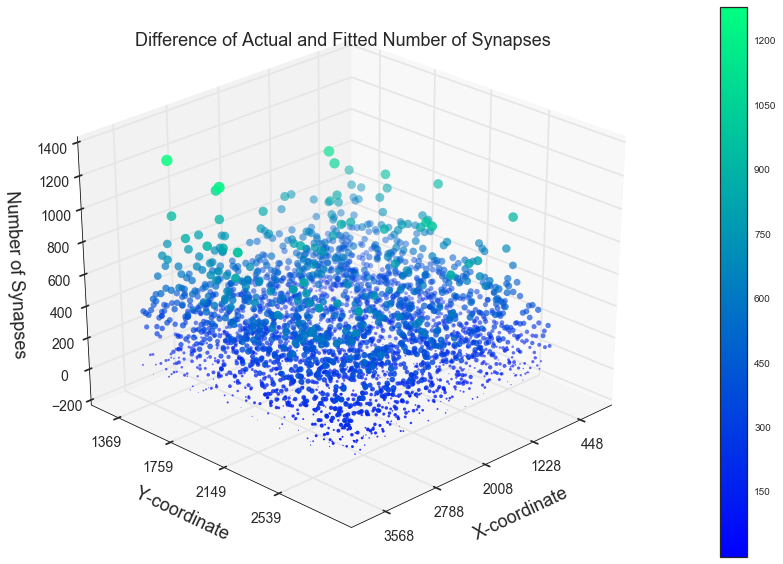

In [11]:
residual = abs(pred - df5['weighted'])

sns.set_style('white')

fs = 18
tfs = 14

ax = plt.figure(figsize = (12, 8)).gca(projection = '3d')
patches = ax.scatter(xs = df5['cx'], ys = df5['cy'], zs = residual, 
                     s = residual/10, c = residual, cmap = 'winter',
                     edgecolors = [0,0,0,0])

plt.xticks(xvals[::20], fontsize=tfs)
plt.yticks(yvals[::10], fontsize=tfs)
#plt.zticks(dfout['weighted'].unique()[0, 1000, 2000, 3000], fontsize=tfs)
#ax.zaxis.set_ticks(dfout['weighted'].unique()[::3])
ax.view_init(azim = 45)
plt.tick_params(axis='both', which='major', labelsize=tfs)
plt.xlabel('X-coordinate', fontsize = fs, labelpad=20)
plt.ylabel('Y-coordinate', fontsize = fs, labelpad=20)
plt.gca().set_zlabel('Number of Synapses', fontsize = fs, labelpad=20)
plt.title("Difference of Actual and Fitted Number of Synapses", fontsize=fs)
plt.colorbar(patches)
plt.tight_layout()
plt.show()

### 3D clustering by synapse density

In [156]:
X = df2.loc[:,('cx','cy','cz')]
Xnew = X.copy()
for i, x in enumerate(xvals):
    Xnew.loc[Xnew['cx']==x, 'cx'] = i
for j, y in enumerate(yvals):
    Xnew.loc[Xnew['cy']==y, 'cy'] = j
for k, z in enumerate(zvals):
    Xnew.loc[Xnew['cz']==z, 'cz'] = k
Xnew.columns = ['i', 'j', 'k']
Xnew.head()

,i,j,k
6292,0,0,0
6293,0,0,1
6294,0,0,2
6295,0,0,3
6296,0,0,4


In [157]:
from sklearn.cluster import DBSCAN

# Compute DBSCAN
db = DBSCAN(eps=1, min_samples=2000).fit(Xnew, sample_weight=df2['weighted'])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 142


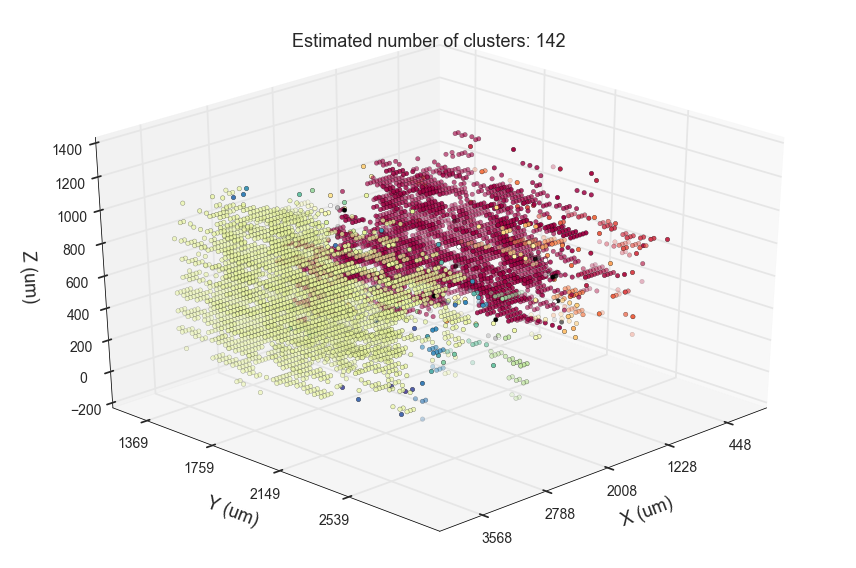

In [160]:
# Plot result

sns.set_style('white')

fs = 18
tfs = 14

# Black removed and is used for noise instead.
ax = plt.figure(figsize = (12, 8)).gca(projection = '3d')
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xyz = X[class_member_mask & core_samples_mask]
    ax.scatter(xyz['cx'], xyz['cy'], xyz['cz'], c=col, label=k)

plt.xticks(xvals[::20], fontsize=tfs)
plt.yticks(yvals[::10], fontsize=tfs)
#plt.zticks(dfout['weighted'].unique()[0, 1000, 2000, 3000], fontsize=tfs)
#ax.zaxis.set_ticks(dfout['weighted'].unique()[::3])
ax.view_init(azim = 45)
plt.tick_params(axis='both', which='major', labelsize=tfs)
plt.xlabel('X (um)', fontsize = fs, labelpad=20)
plt.ylabel('Y (um)', fontsize = fs, labelpad=20)
plt.gca().set_zlabel('Z (um)', fontsize = fs, labelpad=20)
plt.title('Estimated number of clusters: %d' % n_clusters_, fontsize=fs)
# plt.colorbar(patches)
plt.tight_layout()
plt.show()

Cluster sizes:
5599
6074


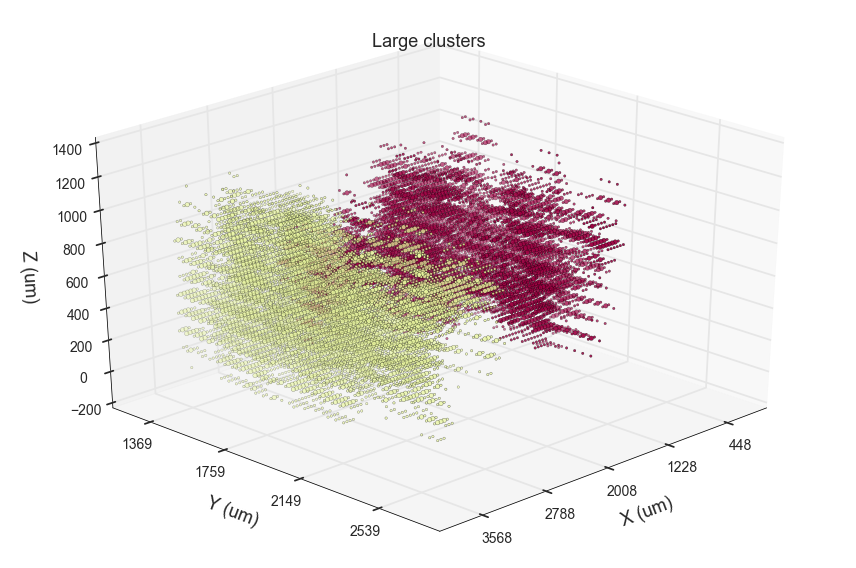

In [163]:
# Plot result

sns.set_style('white')

fs = 18
tfs = 14

# Black removed and is used for noise instead.
ax = plt.figure(figsize = (12, 8)).gca(projection = '3d')
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

print "Cluster sizes:"
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xyz = X[class_member_mask & core_samples_mask]
    if len(xyz)>1000:
        print np.sum(class_member_mask)
        ax.scatter(xyz['cx'], xyz['cy'], xyz['cz'], c=col)
        
        xyz = X[class_member_mask & ~core_samples_mask]
        ax.scatter(xyz['cx'], xyz['cy'], xyz['cz'], c=col, s=6)

plt.xticks(xvals[::20], fontsize=tfs)
plt.yticks(yvals[::10], fontsize=tfs)
#plt.zticks(dfout['weighted'].unique()[0, 1000, 2000, 3000], fontsize=tfs)
#ax.zaxis.set_ticks(dfout['weighted'].unique()[::3])
plt.tick_params(axis='both', which='major', labelsize=tfs)
plt.xlabel('X (um)', fontsize = fs, labelpad=20)
plt.ylabel('Y (um)', fontsize = fs, labelpad=20)
plt.gca().set_zlabel('Z (um)', fontsize = fs, labelpad=20)
plt.title('Large clusters', fontsize=fs)
# plt.colorbar(patches)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/DBSCAN_large_clusters.png', format='png', dpi=300)
ax.view_init(azim = 45)
plt.savefig('./figs/weighted_synapses/DBSCAN_large_clusters_azim_35.png', format='png', dpi=300)
plt.show()

Group 0


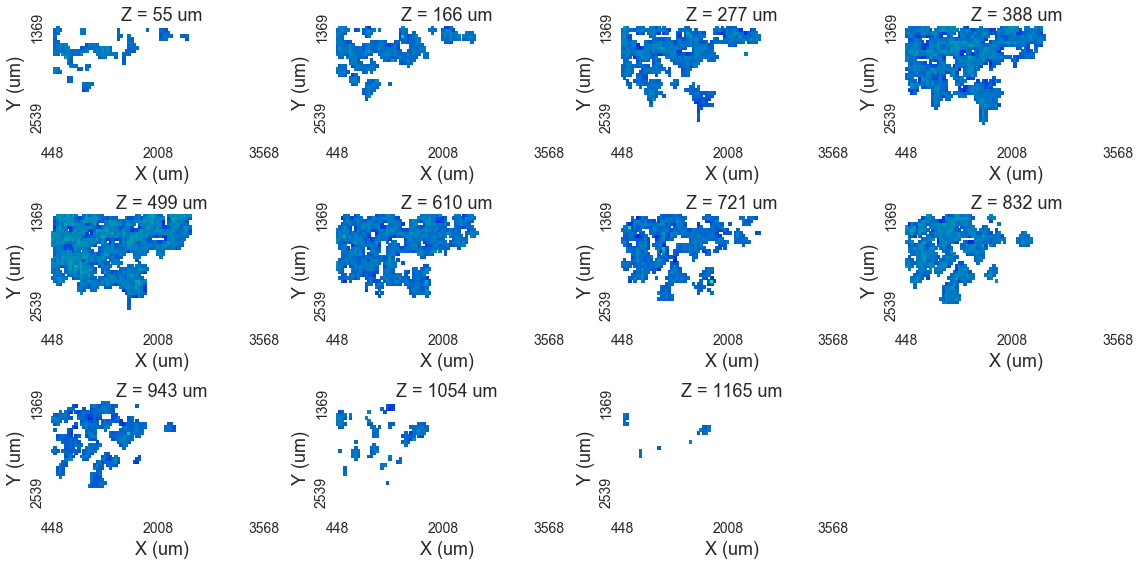

Group 83


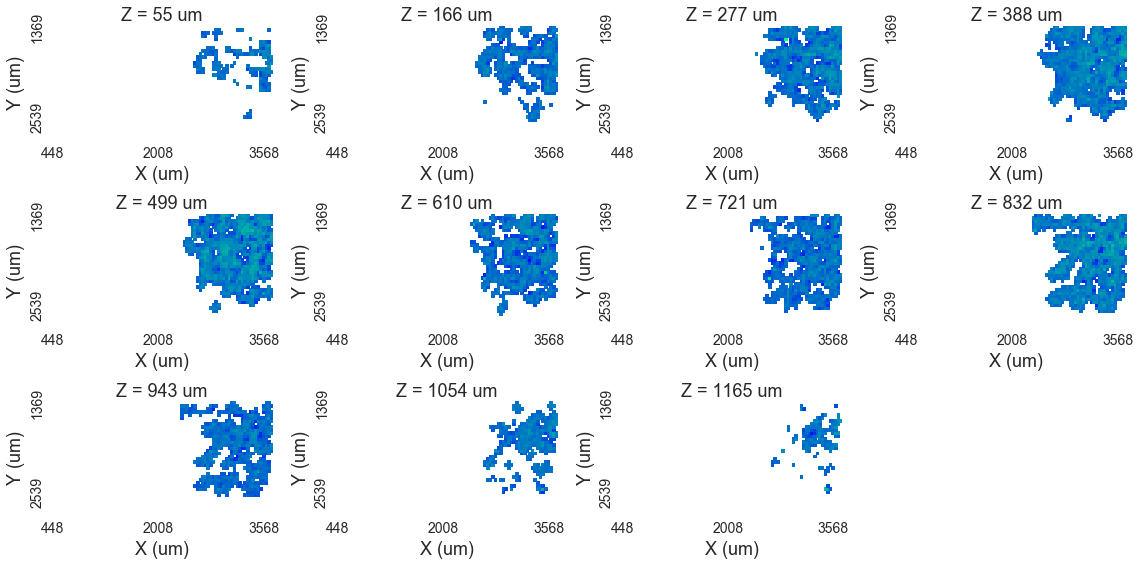

In [16]:
fs = 18
tfs = 14

df2['label']  = labels

for k in [0, 83]:
    plt.figure(figsize=(16,8))
    print "Group", k
    
    for zi, z in enumerate(zvals):
        XY = pd.pivot_table(df2[df2['cz']==z], index='cy', columns='cx', values='weighted')
        XYlabel = pd.pivot_table(df2[df2['cz']==z], index='cy', columns='cx', values='label')
        XYmask = XYlabel != k
        
        plt.subplot(3,4,1+zi)
        sns.heatmap(XY, xticklabels=40, yticklabels=30, 
                    vmin=df2['weighted'].min(), vmax=df2['weighted'].max(), cbar=False, cmap=cm.get_cmap('winter'),
                    mask=XYmask)
        plt.gca().set_title('Z = '+str(z)+' um', fontsize=fs)
        plt.gca().set_xlabel('X (um)', fontsize=fs)
        plt.gca().set_ylabel('Y (um)', fontsize=fs)
        plt.tick_params(axis='both', which='major', labelsize=tfs)

    plt.tight_layout()
    plt.show()

### Prepare data set

In [72]:
xval = df2['cx'].unique()
yval = df2['cy'].unique()
zval = df2['cz'].unique()
ncx = []
ncy = []
ncz = []
navg = []

output_x = [0, 0]
output_y = [0, 0]
output_z = [0, 0]

for i  in (xval):
    val_x = df2[(df2['cx'] == i)]['weighted'].mean()
    output_x = vstack((output_x, [i, val_x]))
for i  in (yval):
    val_y = df2[(df2['cy'] == i)]['weighted'].mean()
    output_y = vstack((output_y, [i, val_y]))
for i  in (zval):
    val_z = df2[(df2['cz'] == i)]['weighted'].mean()
    output_z = vstack((output_z, [i, val_z]))

output_x = pd.DataFrame(output_x) ; output_x.columns = ['cx', 'AVG_weighted']
output_y = pd.DataFrame(output_y) ; output_y.columns = ['cy', 'AVG_weighted']
output_z = pd.DataFrame(output_z) ; output_z.columns = ['cz', 'AVG_weighted']    
m, n = output_x.shape ; output_x = output_x[1:m]
m, n = output_y.shape ; output_y = output_y[1:m]
m, n = output_z.shape ; output_z = output_z[1:m]


### Fitting X-dimension curve (using average synapses)

In [75]:
x_data = output_x['cx']
synapses = output_x['AVG_weighted']

def test_linear_model(x, a, b):
    return a * x + b 
popt = curve_fit(test_linear_model, x_data, synapses)
chi_squared = np.sum(((test_linear_model(x_data, popt[0][0], popt[0][1]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_data)  - len(popt))
print 'Testing linear_model'
print 'The degrees of freedom for this test is', len(x_data)  - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

model_1 = Model(test_linear_model)
result_1 = model_1.fit(synapses, x = x_data, a = popt[0][0], b = popt[0][1])

def test_quadratic_model(x, a, b, c):
    return a * x ** 2 + b * x + c
popt = curve_fit(test_quadratic_model, x_data, synapses)
chi_squared = np.sum(((test_quadratic_model(x_data, popt[0][0], popt[0][1], popt[0][2]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_data)  - len(popt))
print 'Testing quadratic_model'
print 'The degrees of freedom for this test is', len(x_data)  - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

model_2 = Model(test_quadratic_model)
result_2 = model_2.fit(synapses, x = x_data, a = popt[0][0], b = popt[0][1])

def test_cubic_model(x, a, b, c, d):
    return a * x ** 3 + b * x ** 2 + c * x + d 
popt = curve_fit(test_cubic_model, x_data, synapses)
chi_squared = np.sum(((test_cubic_model(x_data, popt[0][0], popt[0][1], popt[0][2], popt[0][3]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_data)  - len(popt))
print 'Testing cubic_model'
print 'The degrees of freedom for this test is', len(x_data)  - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

model_3 = Model(test_cubic_model)
result_3 = model_3.fit(synapses, x = x_data, a = popt[0][0], b = popt[0][1], c = popt[0][2], d = popt[0][3])

def test_quartic_model(x, a, b, c):
    return a * x ** 4 + b * x ** 2 + c   
popt = curve_fit(test_quartic_model, x_data, synapses)
chi_squared = np.sum(((test_quartic_model(x_data, popt[0][0], popt[0][1], popt[0][2]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_data)  - len(popt))
print 'Testing quartic_model'
print 'The degrees of freedom for this test is', len(x_data)  - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

model_4 = Model(test_quartic_model)
result_4 = model_4.fit(synapses, x = x_data, a = popt[0][0], b = popt[0][1], c = popt[0][2])


def test_logarithmic_model(x, a, b):
    return a * np.log(x) + b    
popt = curve_fit(test_logarithmic_model, x_data, synapses)
chi_squared = np.sum(((test_logarithmic_model(x_data, popt[0][0], popt[0][1]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_data)  - len(popt))
print 'Testing logarithmic_model'
print 'The degrees of freedom for this test is', len(x_data)  - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

model_5 = Model(test_logarithmic_model)
result_5 = model_5.fit(synapses, x = x_data, a = popt[0][0], b = popt[0][1])

def test_powerlaw_model(x, a, b):
    return a * (x ** b) 
popt = curve_fit(test_powerlaw_model, x_data, synapses)
chi_squared = np.sum(((test_powerlaw_model(x_data, popt[0][0], popt[0][1]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_data)  - len(popt))

print 'Testing powerlaw_model'
print 'The degrees of freedom for this test is', len(x_data)  - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

model_6 = Model(test_powerlaw_model)
result_6 = model_6.fit(synapses, x = x_data, a = popt[0][0], b = popt[0][1])


Testing linear_model
The degrees of freedom for this test is 82
The chi squared value is:  9078.14
The reduced chi squared value is:  110.71

 - Adding parameter "a"
 - Adding parameter "b"
Testing quadratic_model
The degrees of freedom for this test is 82
The chi squared value is:  4269.20
The reduced chi squared value is:  52.06

 - Adding parameter "a"
 - Adding parameter "b"
 - Adding parameter "c"
Testing cubic_model
The degrees of freedom for this test is 82
The chi squared value is:  4268.00
The reduced chi squared value is:  52.05

 - Adding parameter "a"
 - Adding parameter "b"
 - Adding parameter "c"
 - Adding parameter "d"
Testing quartic_model
The degrees of freedom for this test is 82
The chi squared value is:  4948.63
The reduced chi squared value is:  60.35

 - Adding parameter "a"
 - Adding parameter "b"
 - Adding parameter "c"
Testing logarithmic_model
The degrees of freedom for this test is 82
The chi squared value is:  10972.99
The reduced chi squared value is:  133.

### Fitting Results

In [74]:
print result_1.fit_report()
print result_2.fit_report()
print result_3.fit_report()
print result_4.fit_report()
print result_5.fit_report()
print result_6.fit_report()
print "According to AIC, Cubic Model is so far the best fitted model among 6 candidates."

[[Model]]
    Model(test_linear_model)
[[Fit Statistics]]
    # function evals   = 5
    # data points      = 84
    # variables        = 2
    chi-square         = 9078.142
    reduced chi-square = 110.709
[[Variables]]
    a:   0.00715128 +/- 0.001214 (16.98%) (init= 0.007151287)
    b:   226.743411 +/- 2.758986 (1.22%) (init= 226.7434)
[[Correlations]] (unreported correlations are <  0.100)
    C(a, b)                      = -0.909 

[[Model]]
    Model(test_quadratic_model)
[[Fit Statistics]]
    # function evals   = 5
    # data points      = 84
    # variables        = 2
    chi-square         = 7351.158
    reduced chi-square = 89.648
[[Variables]]
    a:   2.0410e-06 +/- 2.59e-07 (12.69%) (init= 2.040953e-06)
    b:   230.980750 +/- 1.689977 (0.73%) (init= 230.9807)
[[Correlations]] (unreported correlations are <  0.100)
    C(a, b)                      = -0.791 

[[Model]]
    Model(test_cubic_model)
[[Fit Statistics]]
    # function evals   = 8
    # data points      = 84
   

### Plot the actual and fitted results

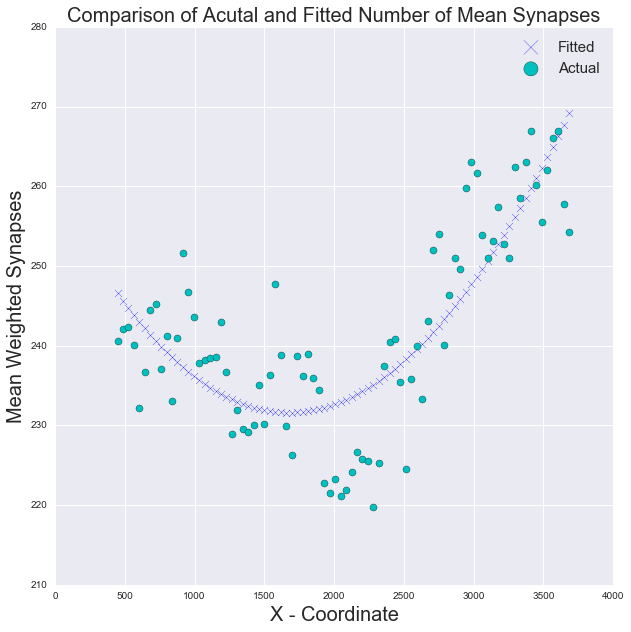

In [8]:
popt = curve_fit(test_cubic_model, x_data, synapses)
predi = test_cubic_model(x_data, popt[0][0], popt[0][1], popt[0][2], popt[0][3])

ax = plt.figure(figsize=(10, 10)).gca()
ax.scatter(x = x_data, y = predi, s = 50, label = "Fitted",
                      c = 'b', marker = 'x')
ax.scatter(x = x_data, y = output_x['AVG_weighted'], s = 50, label = "Actual",
                      c = 'c', marker = 'o' )
ax.set_title("Comparison of Acutal and Fitted Number of Mean Synapses",fontsize = 20)
ax.set_xlabel("X - Coordinate",fontsize = 20)
ax.set_ylabel("Mean Weighted Synapses",fontsize = 20)
plt.legend(fontsize = 15, markerscale = 2)
plt.show()

### Residual Plot

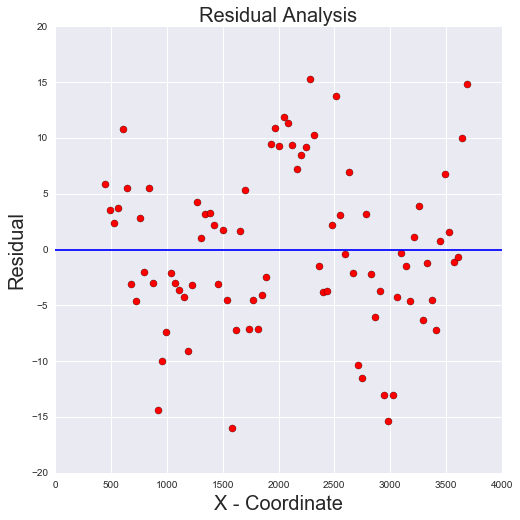

From the residual plot, it's a little bit to see the normality.


In [9]:
Residual = (predi - output_x['AVG_weighted']) 
l = Line2D([0, 5000],[0, 0])                                    
ax = plt.figure(figsize=(8, 8)).gca()
ax.add_line(l) 
ax.scatter(x = x_data, y = Residual, s = 50, label = "Residual", c = 'r', marker = 'o')
ax.set_title("Residual Analysis",fontsize = 20)
ax.set_xlabel("X - Coordinate",fontsize = 20)
ax.set_ylabel("Residual",fontsize = 20)
plt.xlim(0, 4000)
plt.show()

print "From the residual plot, it's a little bit to see the normality."

### Histogram of Error term

Looks like a normal distribution, suggesting that the error term is randomly distributed.


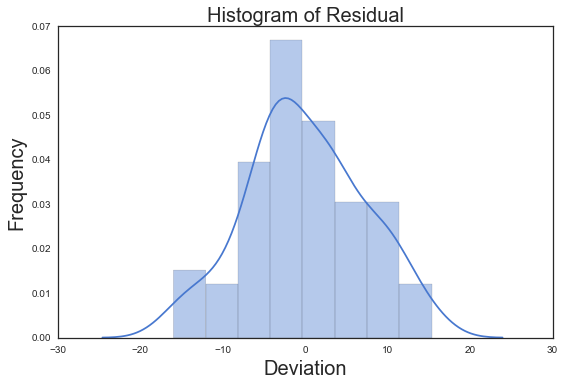

In [10]:
sns.set(style="white", palette="muted", color_codes=True)
ax = sns.distplot(Residual, color = "b")

ax.set_title("Histogram of Residual",fontsize = 20)
ax.set_xlabel("Deviation",fontsize = 20)
ax.set_ylabel("Frequency",fontsize = 20)

plt.tight_layout()
print "Looks like a normal distribution, suggesting that the error term is randomly distributed."

### Fitting Y-dimension curve (using average synapses)

In [11]:
x_data = output_y['cy']
synapses = output_y['AVG_weighted']

def test_linear_model(x, a, b):
    return a * x + b 
popt = curve_fit(test_linear_model, x_data, synapses)
chi_squared = np.sum(((test_linear_model(x_data, popt[0][0], popt[0][1]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_data)  - len(popt))
print 'Testing linear_model'
print 'The degrees of freedom for this test is', len(x_data)  - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

model_1 = Model(test_linear_model)
result_1 = model_1.fit(synapses, x = x_data, a = popt[0][0], b = popt[0][1])

def test_quadratic_model(x, a, b):
    return a * x ** 2 + b 
popt = curve_fit(test_quadratic_model, x_data, synapses)
chi_squared = np.sum(((test_quadratic_model(x_data, popt[0][0], popt[0][1]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_data)  - len(popt))
print 'Testing quadratic_model'
print 'The degrees of freedom for this test is', len(x_data)  - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

model_2 = Model(test_quadratic_model)
result_2 = model_2.fit(synapses, x = x_data, a = popt[0][0], b = popt[0][1])

def test_cubic_model(x, a, b, c, d):
    return a * x ** 3 + b * x ** 2 + c * x + d 
popt = curve_fit(test_cubic_model, x_data, synapses)
chi_squared = np.sum(((test_cubic_model(x_data, popt[0][0], popt[0][1], popt[0][2], popt[0][3]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_data)  - len(popt))
print 'Testing cubic_model'
print 'The degrees of freedom for this test is', len(x_data)  - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

model_3 = Model(test_cubic_model)
result_3 = model_3.fit(synapses, x = x_data, a = popt[0][0], b = popt[0][1], c = popt[0][2], d = popt[0][3])

def test_quartic_model(x, a, b, c):
    return a * x ** 4 + b * x ** 2 + c   
popt = curve_fit(test_quartic_model, x_data, synapses)
chi_squared = np.sum(((test_quartic_model(x_data, popt[0][0], popt[0][1], popt[0][2]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_data)  - len(popt))
print 'Testing quartic_model'
print 'The degrees of freedom for this test is', len(x_data)  - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

model_4 = Model(test_quartic_model)
result_4 = model_4.fit(synapses, x = x_data, a = popt[0][0], b = popt[0][1], c = popt[0][2])


def test_logarithmic_model(x, a, b):
    return a * np.log(x) + b    
popt = curve_fit(test_logarithmic_model, x_data, synapses)
chi_squared = np.sum(((test_logarithmic_model(x_data, popt[0][0], popt[0][1]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_data)  - len(popt))
print 'Testing logarithmic_model'
print 'The degrees of freedom for this test is', len(x_data)  - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

model_5 = Model(test_logarithmic_model)
result_5 = model_5.fit(synapses, x = x_data, a = popt[0][0], b = popt[0][1])

def test_powerlaw_model(x, a, b):
    return a * (x ** b) 
popt = curve_fit(test_powerlaw_model, x_data, synapses)
chi_squared = np.sum(((test_powerlaw_model(x_data, popt[0][0], popt[0][1]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_data)  - len(popt))

print 'Testing powerlaw_model'
print 'The degrees of freedom for this test is', len(x_data)  - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

model_6 = Model(test_powerlaw_model)
result_6 = model_6.fit(synapses, x = x_data, a = popt[0][0], b = popt[0][1])


Testing linear_model
The degrees of freedom for this test is 36
The chi squared value is:  2738.39
The reduced chi squared value is:  76.07

Testing quadratic_model
The degrees of freedom for this test is 36
The chi squared value is:  2096.19
The reduced chi squared value is:  58.23

Testing cubic_model
The degrees of freedom for this test is 36
The chi squared value is:  1096.91
The reduced chi squared value is:  30.47

Testing quartic_model
The degrees of freedom for this test is 36
The chi squared value is:  1428.38
The reduced chi squared value is:  39.68

Testing logarithmic_model
The degrees of freedom for this test is 36
The chi squared value is:  3596.15
The reduced chi squared value is:  99.89

Testing powerlaw_model
The degrees of freedom for this test is 36
The chi squared value is:  3895.84
The reduced chi squared value is:  108.22



### Fitting results

In [12]:
print result_1.fit_report()
print result_2.fit_report()
print result_3.fit_report()
print result_4.fit_report()
print result_5.fit_report()
print result_6.fit_report()
print "According to AIC, Cubic Model is so far the best fitted model among 6 candidates."

[[Model]]
    Model(test_linear_model)
[[Fit Statistics]]
    # function evals   = 5
    # data points      = 38
    # variables        = 2
    chi-square         = 2738.388
    reduced chi-square = 76.066
    Akaike info crit   = 168.601
    Bayesian info crit = 171.876
[[Variables]]
    a:  -0.03937029 +/- 0.003308 (8.40%) (init=-0.03937029)
    b:   323.825145 +/- 7.059117 (2.18%) (init= 323.8251)
[[Correlations]] (unreported correlations are <  0.100)
    C(a, b)                      = -0.980 

[[Model]]
    Model(test_quadratic_model)
[[Fit Statistics]]
    # function evals   = 5
    # data points      = 38
    # variables        = 2
    chi-square         = 2096.193
    reduced chi-square = 58.228
    Akaike info crit   = 158.446
    Bayesian info crit = 161.721
[[Variables]]
    a:  -9.6529e-06 +/- 6.89e-07 (7.14%) (init=-9.65285e-06)
    b:   285.471846 +/- 3.374218 (1.18%) (init= 285.4718)
[[Correlations]] (unreported correlations are <  0.100)
    C(a, b)                     

### Plot the actual and fitted and data

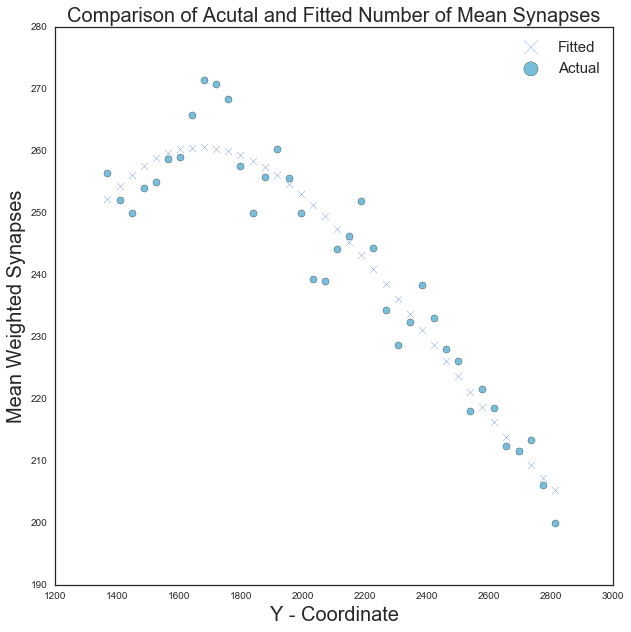

In [13]:
popt = curve_fit(test_cubic_model, x_data, synapses)
predi_y = test_cubic_model(x_data, popt[0][0], popt[0][1], popt[0][2], popt[0][3])

ax = plt.figure(figsize=(10, 10)).gca()
ax.scatter(x = x_data, y = predi_y, s = 50, label = "Fitted",
                      c = 'b', marker = 'x')
ax.scatter(x = x_data, y = output_y['AVG_weighted'], s = 50, label = "Actual",
                      c = 'c', marker = 'o' )
ax.set_title("Comparison of Acutal and Fitted Number of Mean Synapses",fontsize = 20)
ax.set_xlabel("Y - Coordinate",fontsize = 20)
ax.set_ylabel("Mean Weighted Synapses",fontsize = 20)
plt.legend(fontsize = 15, markerscale = 2)
plt.show()

### Residual Plot

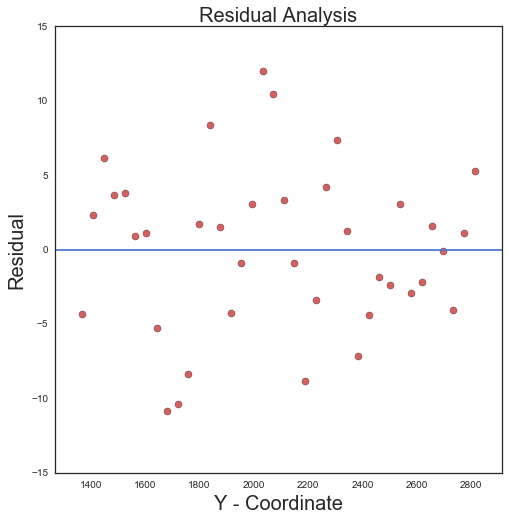

From the residual plot, it's kind of randomly distributed.


In [14]:
Residual_y = (predi_y - output_y['AVG_weighted']) 
l = Line2D([0, 5000],[0, 0])                                    
ax = plt.figure(figsize=(8, 8)).gca()
ax.add_line(l) 
ax.scatter(x = x_data, y = Residual_y, s = 50, label = "Residual", c = 'r', marker = 'o')
ax.set_title("Residual Analysis",fontsize = 20)
ax.set_xlabel("Y - Coordinate",fontsize = 20)
ax.set_ylabel("Residual",fontsize = 20)
plt.xlim(min(output_y['cy']) - 100, max(output_y['cy']) + 100)
plt.show()

print "From the residual plot, it's kind of randomly distributed."

### Histogram of Error term

Although a little bit skewed, it still looks like a normal distribution,
suggesting that the error term is randomly distributed.


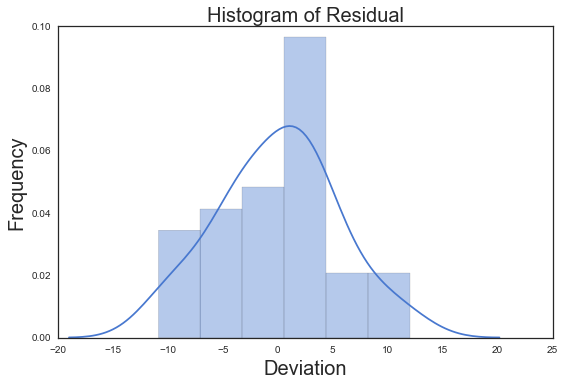

In [15]:
sns.set(style="white", palette="muted", color_codes=True)
ax = sns.distplot(Residual_y, color = "b")

ax.set_title("Histogram of Residual",fontsize = 20)
ax.set_xlabel("Deviation",fontsize = 20)
ax.set_ylabel("Frequency",fontsize = 20)

plt.tight_layout()
print "Although a little bit skewed, it still looks like a normal distribution,"
print "suggesting that the error term is randomly distributed."

### Fitting with complete polynomials

In [146]:
Xmeans = df2.groupby('cx').aggregate(np.mean)
x_point = np.array(Xmeans.index)
synapses = np.array(Xmeans['weighted'])

for deg in range(5):
    popt = P.polyfit(x_point, synapses, deg=deg)
    chi_squared = np.array(np.sum((P.polyval(x_point, popt) - synapses) ** 2))
    reduced_chi_squared = chi_squared / (len(x_point) - len(popt))
    print 'Testing polynomial model of degree =', deg
    print 'The degrees of freedom for this test is', len(x_point) - len(popt)
    print 'The chi squared value is: ', ("%.2f" % chi_squared)
    print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
    print 

popt = P.polyfit(np.log(x_point), synapses, deg=1)
chi_squared = np.sum((P.polyval(np.log(x_point), popt) - synapses) ** 2)
reduced_chi_squared = chi_squared / (len(x_point) - len(popt))
print 'Testing logarithmic model'
print 'The degrees of freedom for this test is', len(x_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

popt = P.polyfit(np.log(x_point), np.log(synapses), deg=1)
chi_squared = np.sum((np.exp(P.polyval(np.log(x_point), popt)) - synapses) ** 2)
reduced_chi_squared = chi_squared / (len(x_point) - len(popt))
print 'Testing powerlaw model'
print 'The degrees of freedom for this test is', len(x_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 



print '1D polynomial of degree = 4 gives the best fit'

Testing polynomial model of degree = 0
The degrees of freedom for this test is 83
The chi squared value is:  12919.57
The reduced chi squared value is:  155.66

Testing polynomial model of degree = 1
The degrees of freedom for this test is 82
The chi squared value is:  9078.14
The reduced chi squared value is:  110.71

Testing polynomial model of degree = 2
The degrees of freedom for this test is 81
The chi squared value is:  4269.20
The reduced chi squared value is:  52.71

Testing polynomial model of degree = 3
The degrees of freedom for this test is 80
The chi squared value is:  4268.00
The reduced chi squared value is:  53.35

Testing polynomial model of degree = 4
The degrees of freedom for this test is 79
The chi squared value is:  2935.33
The reduced chi squared value is:  37.16

Testing logarithmic model
The degrees of freedom for this test is 82
The chi squared value is:  10972.99
The reduced chi squared value is:  133.82

Testing powerlaw model
The degrees of freedom for this

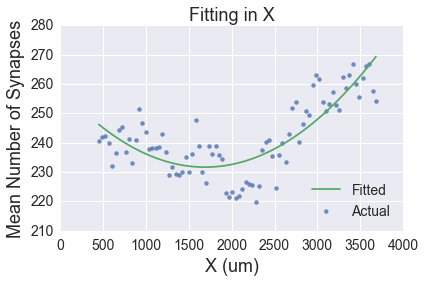

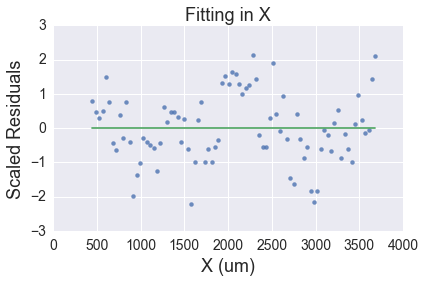

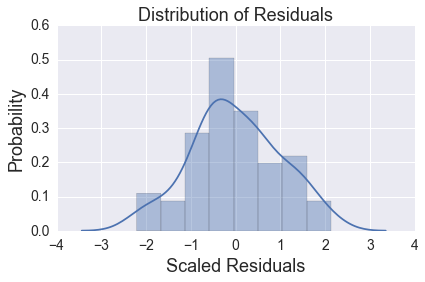

In [147]:
popt = P.polyfit(x_point, synapses, deg=2)
pred = P.polyval(x_point, popt)

Xmeans['pred'] = pred
Xmeans['resid'] = Xmeans['pred']-Xmeans['weighted']
Xmeans['resid'] = (Xmeans['resid']-Xmeans['resid'].mean())/Xmeans['resid'].std()

fs = 18
tfs = 14

plt.figure()
sns.regplot(xvals, Xmeans['weighted'], fit_reg=False, label='Actual')
plt.plot(xvals, Xmeans['pred'], label='Fitted')
plt.legend(loc=4, fontsize=tfs)
plt.xlabel('X (um)', fontsize=fs)
plt.ylabel('Mean Number of Synapses', fontsize=fs)
plt.tick_params(labelsize=tfs)
plt.title('Fitting in X', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/X_quadratic_fit.png', format='png', dpi=300)
plt.show()

plt.figure()
sns.regplot(xvals, Xmeans['resid'], fit_reg=False, label='Actual')
plt.plot(xvals, Xmeans['pred']-Xmeans['pred'], label='Fitted')
plt.xlabel('X (um)', fontsize=fs)
plt.ylabel('Scaled Residuals', fontsize=fs)
plt.tick_params(labelsize=tfs)
plt.title('Fitting in X', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/X_quadratic_fit_resid.png', format='png', dpi=300)
plt.show()

plt.figure()
sns.distplot(Xmeans['resid'])
plt.xlabel('Scaled Residuals', fontsize=fs)
plt.ylabel('Probability', fontsize=fs)
plt.tick_params(labelsize=tfs)
plt.title('Distribution of Residuals', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/X_quadratic_fit_resid_hist.png', format='png', dpi=300)
plt.show()

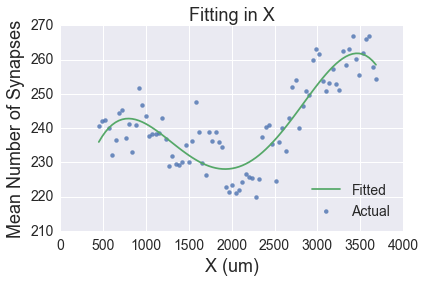

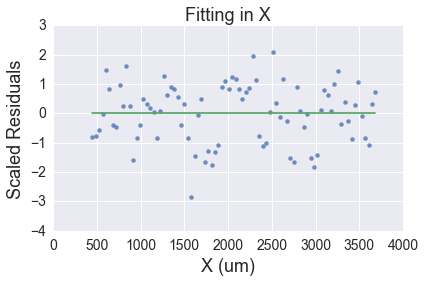

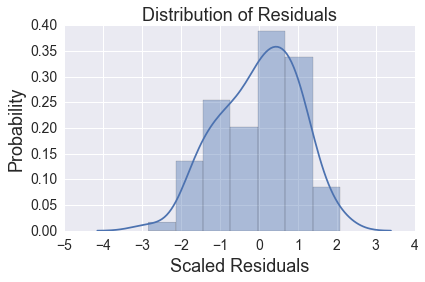

In [148]:
popt = P.polyfit(x_point, synapses, deg=4)
pred = P.polyval(x_point, popt)

Xmeans['pred'] = pred
Xmeans['resid'] = Xmeans['pred']-Xmeans['weighted']
Xmeans['resid'] = (Xmeans['resid']-Xmeans['resid'].mean())/Xmeans['resid'].std()

fs = 18
tfs = 14

plt.figure()
sns.regplot(xvals, Xmeans['weighted'], fit_reg=False, label='Actual')
plt.plot(xvals, Xmeans['pred'], label='Fitted')
plt.legend(loc=4, fontsize=tfs)
plt.xlabel('X (um)', fontsize=fs)
plt.ylabel('Mean Number of Synapses', fontsize=fs)
plt.tick_params(labelsize=tfs)
plt.title('Fitting in X', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/X_quartic_fit.png', format='png', dpi=300)
plt.show()

plt.figure()
sns.regplot(xvals, Xmeans['resid'], fit_reg=False, label='Actual')
plt.plot(xvals, Xmeans['pred']-Xmeans['pred'], label='Fitted')
plt.xlabel('X (um)', fontsize=fs)
plt.ylabel('Scaled Residuals', fontsize=fs)
plt.tick_params(labelsize=tfs)
plt.title('Fitting in X', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/X_quartic_fit_resid.png', format='png', dpi=300)
plt.show()

plt.figure()
sns.distplot(Xmeans['resid'])
plt.xlabel('Scaled Residuals', fontsize=fs)
plt.ylabel('Probability', fontsize=fs)
plt.tick_params(labelsize=tfs)
plt.title('Distribution of Residuals', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/X_quartic_fit_resid_hist.png', format='png', dpi=300)
plt.show()

In [166]:
Ymeans = df2.groupby('cy').aggregate(np.mean)
y_point = np.array(Ymeans.index)
synapses = np.array(Ymeans['weighted'])

for deg in range(5):
    popt = P.polyfit(y_point, synapses, deg=deg)
    chi_squared = np.array(np.sum((P.polyval(y_point, popt) - synapses) ** 2))
    reduced_chi_squared = chi_squared / (len(y_point) - len(popt))
    print 'Testing polynomial model of degree =', deg
    print 'The degrees of freedom for this test is', len(y_point) - len(popt)
    print 'The chi squared value is: ', ("%.2f" % chi_squared)
    print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
    print 

popt = P.polyfit(np.log(y_point), synapses, deg=1)
chi_squared = np.sum((P.polyval(np.log(y_point), popt) - synapses) ** 2)
reduced_chi_squared = chi_squared / (len(y_point) - len(popt))
print 'Testing logarithmic model'
print 'The degrees of freedom for this test is', len(y_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

popt = P.polyfit(np.log(y_point), np.log(synapses), deg=1)
chi_squared = np.sum((np.exp(P.polyval(np.log(y_point), popt)) - synapses) ** 2)
reduced_chi_squared = chi_squared / (len(y_point) - len(popt))
print 'Testing powerlaw model'
print 'The degrees of freedom for this test is', len(y_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 



print '1D polynomial of degree = 4 gives the best fit'

Testing polynomial model of degree = 0
The degrees of freedom for this test is 37
The chi squared value is:  13511.35
The reduced chi squared value is:  365.17

Testing polynomial model of degree = 1
The degrees of freedom for this test is 36
The chi squared value is:  2738.39
The reduced chi squared value is:  76.07

Testing polynomial model of degree = 2
The degrees of freedom for this test is 35
The chi squared value is:  1276.74
The reduced chi squared value is:  36.48

Testing polynomial model of degree = 3
The degrees of freedom for this test is 34
The chi squared value is:  1096.91
The reduced chi squared value is:  32.26

Testing polynomial model of degree = 4
The degrees of freedom for this test is 33
The chi squared value is:  998.71
The reduced chi squared value is:  30.26

Testing logarithmic model
The degrees of freedom for this test is 36
The chi squared value is:  3596.15
The reduced chi squared value is:  99.89

Testing powerlaw model
The degrees of freedom for this tes

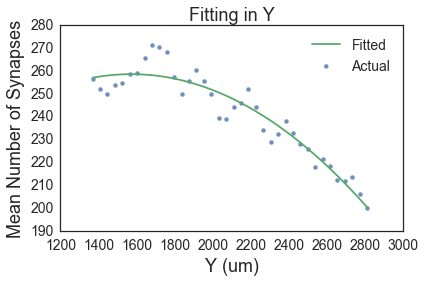

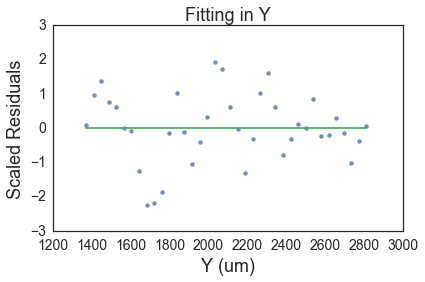

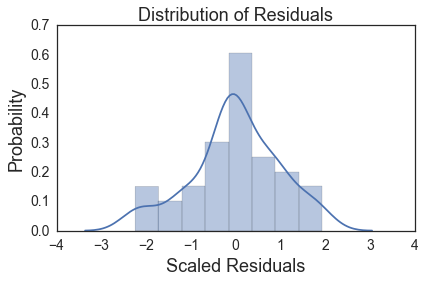

In [167]:
popt = P.polyfit(y_point, synapses, deg=2)
pred = P.polyval(y_point, popt)

Ymeans['pred'] = pred
Ymeans['resid'] = Ymeans['pred']-Ymeans['weighted']
Ymeans['resid'] = (Ymeans['resid']-Ymeans['resid'].mean())/Ymeans['resid'].std()

fs = 18
tfs = 14

plt.figure()
sns.regplot(y_point, Ymeans['weighted'], fit_reg=False, label='Actual')
plt.plot(y_point, Ymeans['pred'], label='Fitted')
plt.legend(fontsize=tfs)
plt.xlabel('Y (um)', fontsize=fs)
plt.ylabel('Mean Number of Synapses', fontsize=fs)
plt.tick_params(labelsize=tfs)
plt.title('Fitting in Y', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/Y_quadratic_fit.png', format='png', dpi=300)
plt.show()

plt.figure()
sns.regplot(y_point, Ymeans['resid'], fit_reg=False, label='Actual')
plt.plot(y_point, Ymeans['pred']-Ymeans['pred'], label='Fitted')
plt.xlabel('Y (um)', fontsize=fs)
plt.ylabel('Scaled Residuals', fontsize=fs)
plt.tick_params(labelsize=tfs)
plt.title('Fitting in Y', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/Y_quadratic_fit_resid.png', format='png', dpi=300)
plt.show()

plt.figure()
sns.distplot(Ymeans['resid'])
plt.xlabel('Scaled Residuals', fontsize=fs)
plt.ylabel('Probability', fontsize=fs)
plt.tick_params(labelsize=tfs)
plt.title('Distribution of Residuals', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/Y_quadratic_fit_resid_hist.png', format='png', dpi=300)
plt.show()

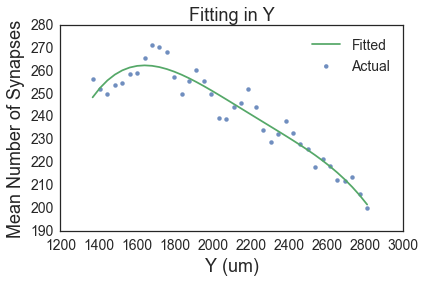

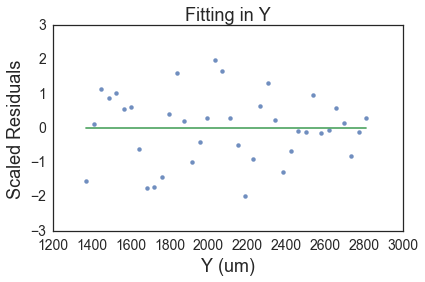

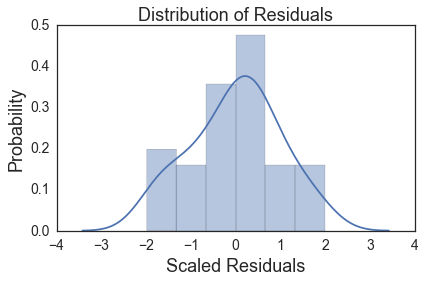

In [168]:
popt = P.polyfit(y_point, synapses, deg=4)
pred = P.polyval(y_point, popt)

Ymeans['pred'] = pred
Ymeans['resid'] = Ymeans['pred']-Ymeans['weighted']
Ymeans['resid'] = (Ymeans['resid']-Ymeans['resid'].mean())/Ymeans['resid'].std()

fs = 18
tfs = 14

plt.figure()
sns.regplot(y_point, Ymeans['weighted'], fit_reg=False, label='Actual')
plt.plot(y_point, Ymeans['pred'], label='Fitted')
plt.legend(fontsize=tfs)
plt.xlabel('Y (um)', fontsize=fs)
plt.ylabel('Mean Number of Synapses', fontsize=fs)
plt.tick_params(labelsize=tfs)
plt.title('Fitting in Y', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/Y_quartic_fit.png', format='png', dpi=300)
plt.show()

plt.figure()
sns.regplot(y_point, Ymeans['resid'], fit_reg=False, label='Actual')
plt.plot(y_point, Ymeans['pred']-Ymeans['pred'], label='Fitted')
plt.xlabel('Y (um)', fontsize=fs)
plt.ylabel('Scaled Residuals', fontsize=fs)
plt.tick_params(labelsize=tfs)
plt.title('Fitting in Y', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/Y_quartic_fit_resid.png', format='png', dpi=300)
plt.show()

plt.figure()
sns.distplot(Ymeans['resid'])
plt.xlabel('Scaled Residuals', fontsize=fs)
plt.ylabel('Probability', fontsize=fs)
plt.tick_params(labelsize=tfs)
plt.title('Distribution of Residuals', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/Y_quartic_fit_resid_hist.png', format='png', dpi=300)
plt.show()

In [134]:
Zmeans = df2.groupby('cz').aggregate(np.mean)
z_point = np.array(Zmeans.index)
synapses = np.array(Zmeans['weighted'])

for deg in range(5):
    popt = P.polyfit(z_point, synapses, deg=deg)
    chi_squared = np.array(np.sum((P.polyval(z_point, popt) - synapses) ** 2))
    reduced_chi_squared = chi_squared / (len(z_point) - len(popt))
    print 'Testing polynomial model of degree =', deg
    print 'The degrees of freedom for this test is', len(z_point) - len(popt)
    print 'The chi squared value is: ', ("%.2f" % chi_squared)
    print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
    print 

popt = P.polyfit(np.log(z_point), synapses, deg=1)
chi_squared = np.sum((P.polyval(np.log(z_point), popt) - synapses) ** 2)
reduced_chi_squared = chi_squared / (len(z_point) - len(popt))
print 'Testing logarithmic model'
print 'The degrees of freedom for this test is', len(y_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

popt = P.polyfit(np.log(z_point), np.log(synapses), deg=1)
chi_squared = np.sum((np.exp(P.polyval(np.log(z_point), popt)) - synapses) ** 2)
reduced_chi_squared = chi_squared / (len(z_point) - len(popt))
print 'Testing powerlaw model'
print 'The degrees of freedom for this test is', len(y_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 



print '1D polynomial of degree = 2 gives the best fit'

Testing polynomial model of degree = 0
The degrees of freedom for this test is 10
The chi squared value is:  4628.56
The reduced chi squared value is:  462.86

Testing polynomial model of degree = 1
The degrees of freedom for this test is 9
The chi squared value is:  4568.59
The reduced chi squared value is:  507.62

Testing polynomial model of degree = 2
The degrees of freedom for this test is 8
The chi squared value is:  2161.29
The reduced chi squared value is:  270.16

Testing polynomial model of degree = 3
The degrees of freedom for this test is 7
The chi squared value is:  2098.25
The reduced chi squared value is:  299.75

Testing polynomial model of degree = 4
The degrees of freedom for this test is 6
The chi squared value is:  2096.07
The reduced chi squared value is:  349.34

Testing logarithmic model
The degrees of freedom for this test is 36
The chi squared value is:  4521.71
The reduced chi squared value is:  502.41

Testing powerlaw model
The degrees of freedom for this te

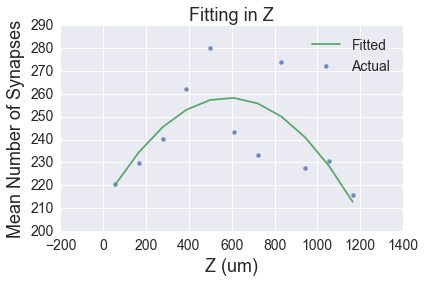

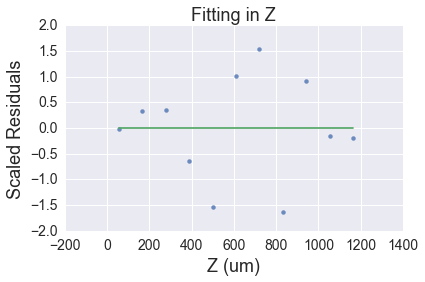

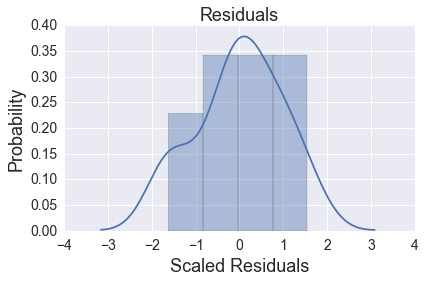

In [139]:
popt = P.polyfit(z_point, synapses, deg=2)
pred = P.polyval(z_point, popt)

Zmeans['pred'] = pred
Zmeans['resid'] = Zmeans['pred']-Zmeans['weighted']
Zmeans['resid'] = (Zmeans['resid']-Zmeans['resid'].mean())/Zmeans['resid'].std()

fs = 18
tfs = 14

plt.figure()
sns.regplot(z_point, Zmeans['weighted'], fit_reg=False, label='Actual')
plt.plot(z_point, Zmeans['pred'], label='Fitted')
plt.legend(fontsize=tfs)
plt.xlabel('Z (um)', fontsize=fs)
plt.ylabel('Mean Number of Synapses', fontsize=fs)
plt.tick_params(labelsize=tfs)
plt.title('Fitting in Z', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/Z_quadratic_fit.png', format='png', dpi=300)
plt.show()

plt.figure()
sns.regplot(z_point, Zmeans['resid'], fit_reg=False, label='Actual')
plt.plot(z_point, Zmeans['pred']-Zmeans['pred'], label='Fitted')
plt.xlabel('Z (um)', fontsize=fs)
plt.ylabel('Scaled Residuals', fontsize=fs)
plt.tick_params(labelsize=tfs)
plt.title('Fitting in Z', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/Z_quadratic_fit_resid.png', format='png', dpi=300)
plt.show()

plt.figure()
sns.distplot(Zmeans['resid'])
plt.xlabel('Scaled Residuals', fontsize=fs)
plt.ylabel('Probability', fontsize=fs)
plt.tick_params(labelsize=tfs)
plt.title('Distribution of Residuals', fontsize=fs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/Z_quadratic_fit_resid_hist.png', format='png', dpi=300)
plt.show()